# tinycodec

This notebook will track my experiments with video encoding and developing the tinycodec software/hardware codec.

**Resources**
- https://last.hit.bme.hu/download/vidtech/k%C3%B6nyvek/Iain%20E.%20Richardson%20-%20H264%20(2nd%20edition).pdf
- https://github.com/leandromoreira/digital_video_introduction
- https://en.wikipedia.org/wiki/Discrete_cosine_transform
- https://en.wikipedia.org/wiki/Block-matching_algorithm
- https://arxiv.org/pdf/1702.00817

## Frames

In [52]:
import ffmpeg
import numpy as np
from matplotlib import pyplot as plt
from scipy.fft import dct, idct
from IPython.display import Math
from IPython.display import display

%matplotlib inline

In [53]:
def get_video_stats(filename):
    probe = ffmpeg.probe(filename)
    video_stream = next((stream for stream in probe['streams'] if stream['codec_type'] == 'video'), None)
    if video_stream:
        return int(video_stream['width']), int(video_stream['height']), int(video_stream['avg_frame_rate'].split('/')[0])
    else:
        return None, None, None

def frame(i):
    width, height, fps = get_video_stats('data/test.mov')
    out, _ = (
        ffmpeg
        .input('data/test.mov', ss=i/fps)
        .output('pipe:', vframes=1, format='rawvideo', pix_fmt='rgb24')
        .run(capture_stdout=True, capture_stderr=True)
    )
    return np.frombuffer(out, np.uint8).reshape([height, width, 3])

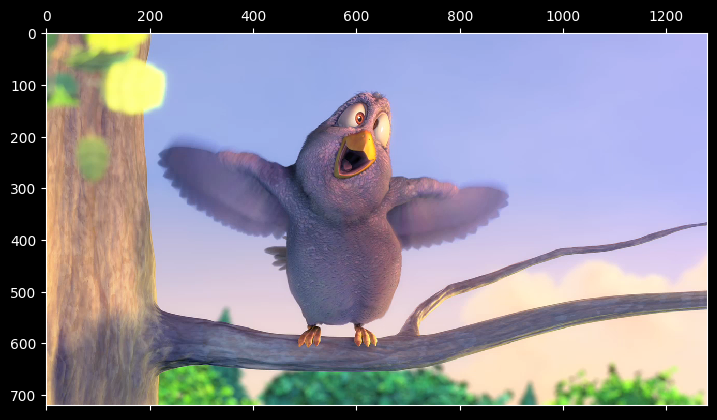

In [54]:
N, i, j = 482, 43, 14
plt.matshow(frame(N));

## YUV Color Space

In [55]:
def rgb2yuv(rgb):
    xform = np.array([[.299, .587, .114], [-.1687, -.3313, .5], [.5, -.4187, -.0813]])
    ycbcr = rgb.dot(xform.T)
    ycbcr[:,:,[1,2]] += 128
    return np.uint8(ycbcr)

In [56]:
def plot_yuv(y,u,v):
    _, ax = plt.subplots(1,3, figsize=(12,4))
    ax[0].matshow(y, label='Y', cmap='grey')
    ax[0].title.set_text('Y')
    ax[1].matshow(u, label='U', cmap='grey')
    ax[1].title.set_text('U')
    ax[2].matshow(v, label='V', cmap='grey')
    ax[2].title.set_text('V')
    plt.show()

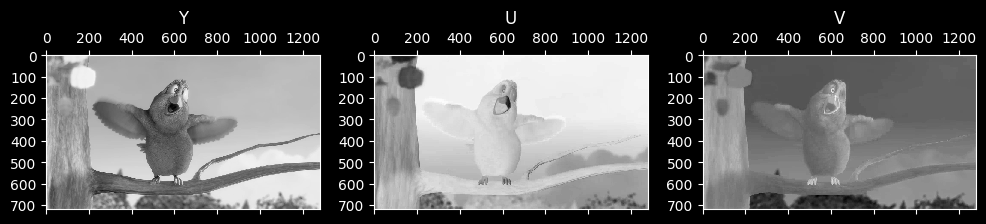

In [57]:
yuv = rgb2yuv(frame(N))
plot_yuv(y=yuv[:,:,0],u=yuv[:,:,1],v=yuv[:,:,2])

## Chroma Subsampling

In [58]:
def chroma_subsample(yuv):
    y = yuv[:,:,0]
    u = yuv[:,:,1]
    v = yuv[:,:,2]
    ud = u[::2, ::2]
    vd = v[::2, ::2]
    uu = np.repeat(np.repeat(ud, 2, axis=0), 2, axis=1)
    vu = np.repeat(np.repeat(vd, 2, axis=0), 2, axis=1)
    return np.stack((y, uu, vu), axis=-1)

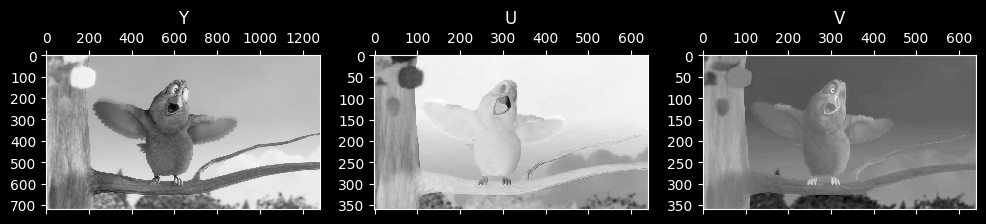

In [59]:
yuv = chroma_subsample(rgb2yuv(frame(N)))
plot_yuv(y=yuv[:,:,0],u=yuv[::2,::2,1],v=yuv[::2,::2,2])

## Macroblocks

In [60]:
def macroblock(x, i, j):
    return x[i*16:(i+1)*16, j*16:(j+1)*16]

def macroblock1(N, i, j):
    x = chroma_subsample(rgb2yuv(frame(N)))
    return macroblock(x, i, j)

In [61]:
def plot_macroblock(mb):
    _, ax = plt.subplots(1,3, figsize=(12,4))
    ax[0].matshow(mb[:,:,0], label='Y', cmap='grey')
    ax[0].title.set_text('Y')
    ax[1].matshow(mb[::2,::2,1], label='U', cmap='grey')
    ax[1].title.set_text('U')
    ax[2].matshow(mb[::2,::2,2], label='V', cmap='grey')
    ax[2].title.set_text('V')
    plt.show()

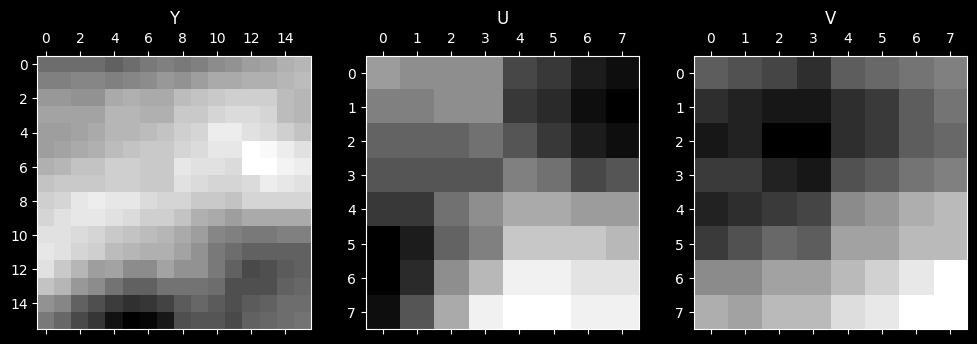

In [62]:

mb = macroblock1(N, i, j)
plot_macroblock(mb)

## Inter Prediction

In [63]:
def mad(X, Y):
    N = X.size
    return np.sum(np.abs(X - Y)) / (N**2)

In [64]:
def inter_predict(N, i, j):
    X = chroma_subsample(rgb2yuv(frame(N-1)))
    Y = chroma_subsample(rgb2yuv(frame(N)))
    mb0 = macroblock(X, i, j)
    mb1 = macroblock(Y, i, j)
    best_mv = (0,0)
    best_mb = mb0
    best_mad = mad(mb1, mb0)
    for di in range(-1,2):
        for dj in range(-1,2):
            mb0 = macroblock(Y, i+di, j+dj)
            score = mad(mb1, mb0)
            if score < best_mad:
                best_mad = score
                best_mb = mb0
                best_mv = (di,dj)
    return best_mb, best_mv, best_mad

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

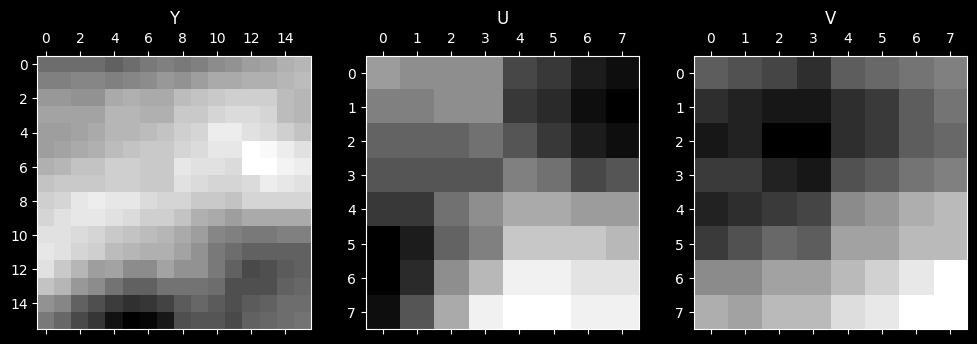

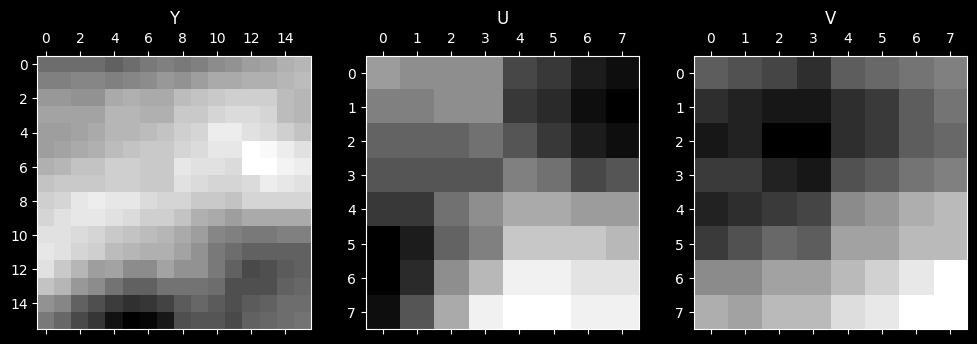

In [65]:
mb = macroblock1(N, i, j)
pred2, mv, score = inter_predict(N, i, j)
residual = mb - pred2

display(Math(f"\\textsf{{MAD}} = {mad(pred2, mb)}"))
display(Math(f"\\textsf{{MAD}}_\\text{{ref}} = {mad(np.zeros_like(mb), mb)}"))
display(Math(f"\\textsf{{MV}} = {mv}"))

plot_macroblock(pred2)
plot_macroblock(mb)

## Discrete Cosine Transform

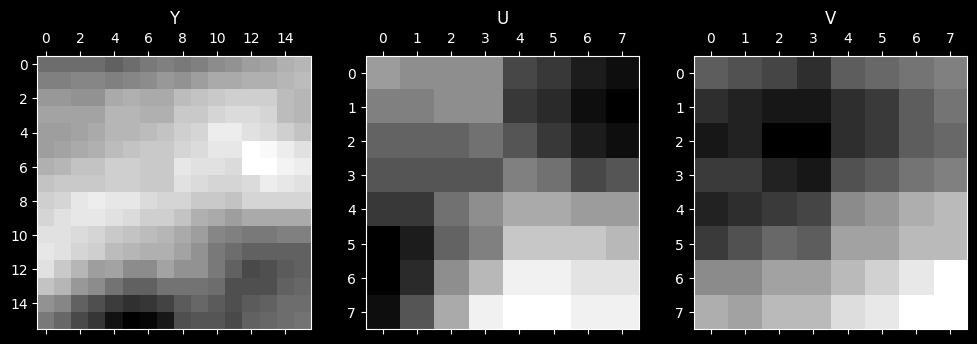

In [66]:
residual = macroblock1(N, i, j)
plot_macroblock(residual)

In [70]:
def split(array, nrows, ncols):
    """Split a matrix into sub-matrices."""

    _, h = array.shape
    return (array.reshape(h//nrows, nrows, -1, ncols)
                 .swapaxes(1, 2)
                 .reshape(-1, nrows, ncols))

def forward_dct_luma(Y):
    A, B, C, D = split(Y, 8, 8)
    Ac, Bc, Cc, Dc = dct(A, type=2, norm='ortho'), dct(B, type=2, norm='ortho'), dct(C, type=2, norm='ortho'), dct(D, type=2, norm='ortho')
    return np.block([[Ac, Bc], [Cc, Dc]])

def forward_dct_chroma(C):
    return dct(C, type=2, norm='ortho')

def inverse_dct_luma(Y):
    Ac, Bc, Cc, Dc = split(Y, 8, 8)
    A, B, C, D = idct(Ac, type=2, norm='ortho'), idct(Bc, type=2, norm='ortho'), idct(Cc, type=2, norm='ortho'), idct(Dc, type=2, norm='ortho')
    return np.block([[A, B], [C, D]])

def inverse_dct_chroma(C):
    return idct(C, type=2, norm='ortho')

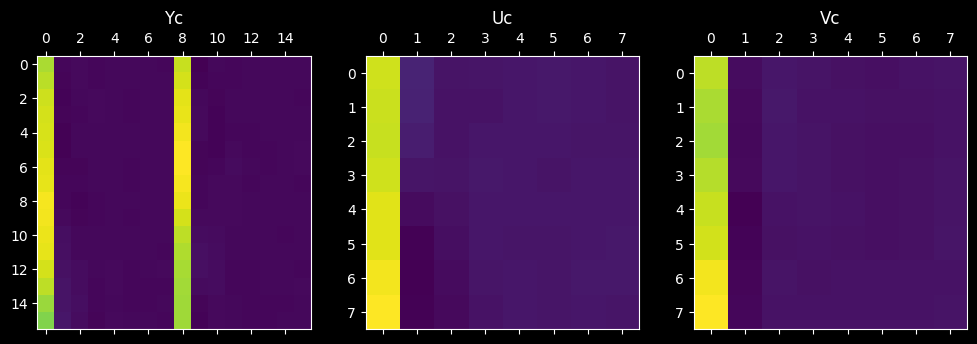

In [71]:
Yc = forward_dct_luma(residual[:,:,0])
Uc = forward_dct_chroma(residual[::2,::2,1])
Vc = forward_dct_chroma(residual[::2,::2,2])

# plot each of the channels
_, ax = plt.subplots(1,3, figsize=(12,4))
ax[0].matshow(Yc, label='Y')
ax[0].title.set_text('Yc')
ax[1].matshow(Uc, label='U')
ax[1].title.set_text('Uc')
ax[2].matshow(Vc, label='V')
ax[2].title.set_text('Vc')
plt.show()

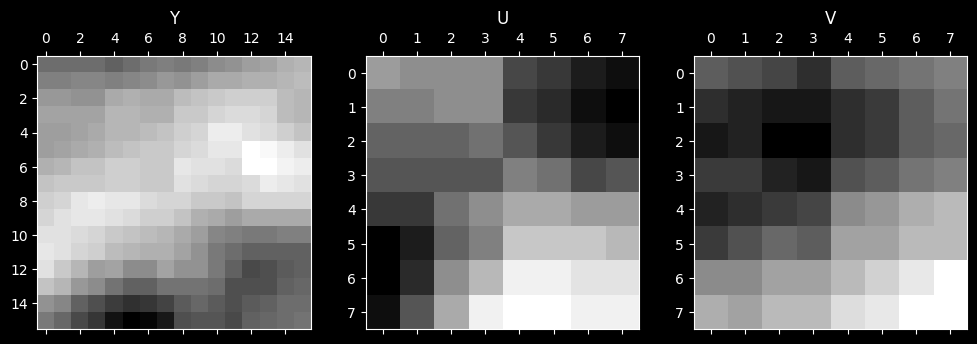

In [73]:
Y = inverse_dct_luma(Yc)
U = inverse_dct_chroma(Uc)
V = inverse_dct_chroma(Vc)

# plot each of the channels
_, ax = plt.subplots(1,3, figsize=(12,4))
ax[0].matshow(Y, label='Y', cmap='grey')
ax[0].title.set_text('Y')
ax[1].matshow(U, label='U', cmap='grey')
ax[1].title.set_text('U')
ax[2].matshow(V, label='V', cmap='grey')
ax[2].title.set_text('V')
plt.show()

## Quantization